In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [2]:
# Load and normalize CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0



In [3]:
# CIFAR-100 fine label names
fine_label_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

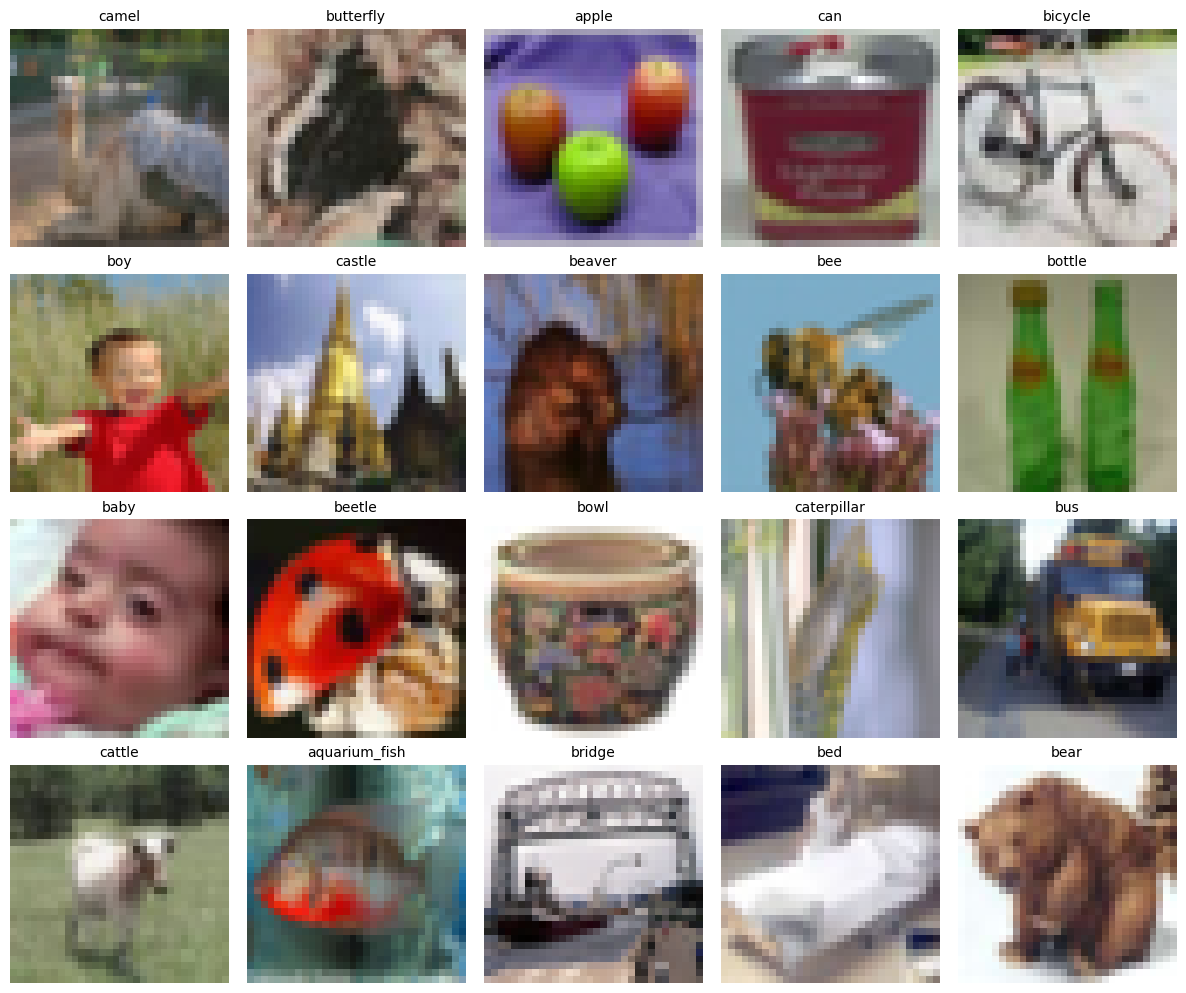

In [4]:
# Select first 20 classes
selected_classes = list(range(20))
class_mapping = {cls: i for i, cls in enumerate(selected_classes)}

# Filter training and test data
train_mask = np.isin(y_train, selected_classes).flatten()
x_train_20 = x_train[train_mask]
y_train_20 = np.array([class_mapping[label[0]] for label in y_train[train_mask]])

test_mask = np.isin(y_test, selected_classes).flatten()
x_test_20 = x_test[test_mask]
y_test_20 = np.array([class_mapping[label[0]] for label in y_test[test_mask]])
y_test_orig = y_test[test_mask]

# Show 1 image per class
one_image_per_class = {}
label_name_per_class = {}
for img, label in zip(x_test_20, y_test_orig):
    lbl = label[0]
    if lbl not in one_image_per_class:
        one_image_per_class[lbl] = img
        label_name_per_class[lbl] = fine_label_names[lbl]
    if len(one_image_per_class) == 20:
        break

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for idx, (label_id, image) in enumerate(one_image_per_class.items()):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(label_name_per_class[label_id], fontsize=10)
plt.tight_layout()
plt.show()



### Define pre-trained models

In [5]:
# Define models and input sizes
model_configs = [
    ("ResNet50", 32), ("VGG16", 32), ("VGG19", 32), ("DenseNet121", 32),
    ("MobileNetV2", 32), ("InceptionV3", 75), ("Xception", 75),
    ("EfficientNetB0", 32), ("NASNetMobile", 96), ("ResNet101", 32)
]

### Container for store the result

In [6]:
# Track results
model_names = []
accuracies = []
inference_times = []
model_sizes_mb = []

### Train the Model

In [7]:
# Loop through models
for name, input_size in model_configs:
    print(f"\nEvaluating {name}...")
    try:
        x_train_resized = tf.image.resize(x_train_20, [input_size, input_size])
        x_test_resized = tf.image.resize(x_test_20, [input_size, input_size])

        base_model = getattr(tf.keras.applications, name)(
            weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3)
        )
        base_model.trainable = False

        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(20, activation='softmax')
        ])

        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        model.fit(x_train_resized, y_train_20, epochs=5, batch_size=32, verbose=0)

        start = time.time()
        preds = model.predict(x_test_resized, batch_size=32, verbose=0)
        end = time.time()
        avg_time_per_image = (end - start) / len(x_test_resized)

        pred_labels = np.argmax(preds, axis=1)
        acc = np.mean(pred_labels == y_test_20)

        model_path = f"./tmp_{name}.h5"
        model.save(model_path)
        size_mb = os.path.getsize(model_path) / (1024 * 1024)
        os.remove(model_path)

        model_names.append(name)
        accuracies.append(acc * 100)
        inference_times.append(avg_time_per_image * 1000)
        model_sizes_mb.append(size_mb)

    except Exception as e:
        print(f"Skipping {name}: {e}")
        model_names.append(name)
        accuracies.append(0)
        inference_times.append(0)
        model_sizes_mb.append(0)


Evaluating ResNet50...


d:\sangita-mam\yolov1_widerface\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Evaluating VGG16...

Evaluating VGG19...

Evaluating DenseNet121...

Evaluating MobileNetV2...

Evaluating InceptionV3...

Evaluating Xception...

Evaluating EfficientNetB0...

Evaluating NASNetMobile...

Evaluating ResNet101...


### Plot the barchart

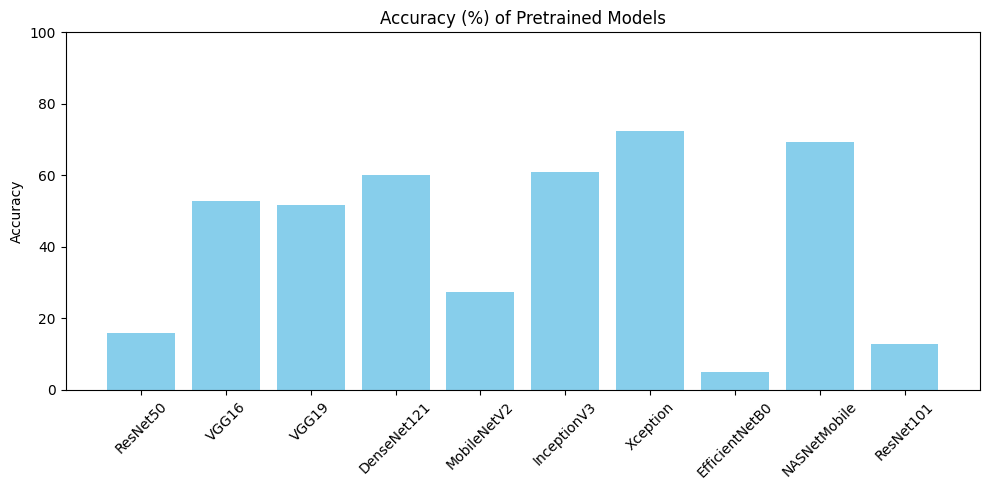

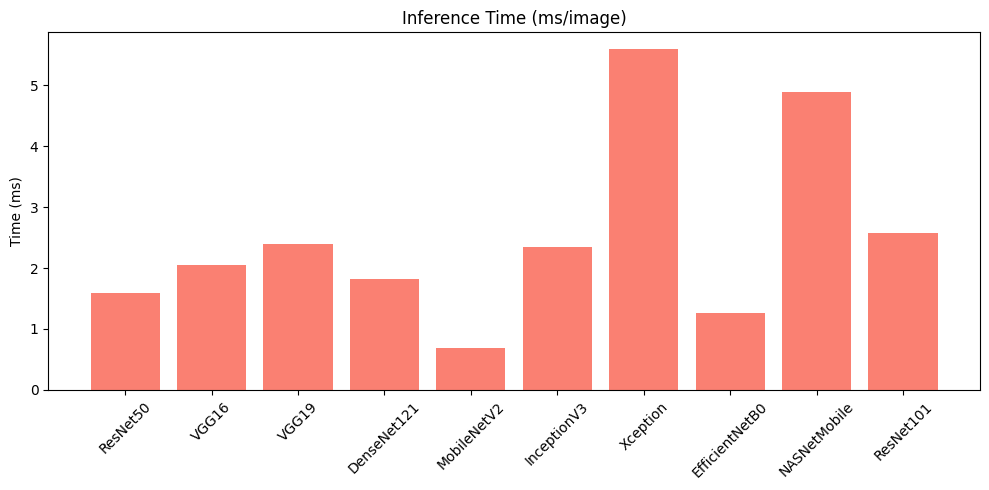

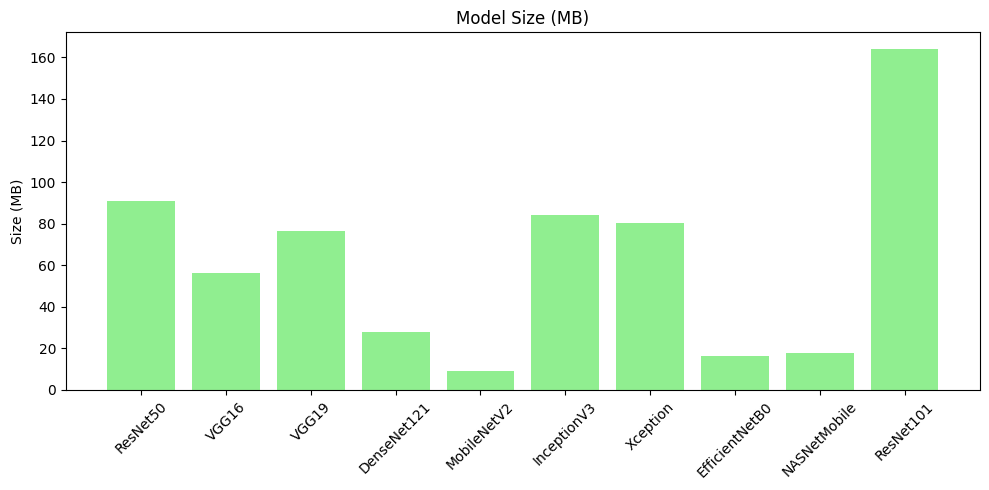

In [8]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color='skyblue')
plt.title("Accuracy (%) of Pretrained Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Plot Inference Time
plt.figure(figsize=(10, 5))
plt.bar(model_names, inference_times, color='salmon')
plt.title("Inference Time (ms/image)")
plt.ylabel("Time (ms)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Model Size
plt.figure(figsize=(10, 5))
plt.bar(model_names, model_sizes_mb, color='lightgreen')
plt.title("Model Size (MB)")
plt.ylabel("Size (MB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
